In [ ]:
import pandas as pd
import numpy as np
import json
import scipy.signal
import matplotlib.pyplot as plt

def vel_filter(ang_vel_all):
    b, a = scipy.signal.butter(2, 0.1, 'lowpass')
    return scipy.signal.filtfilt(b, a, ang_vel_all)

# Load data
data = pd.read_csv('GazeDataContrast/gaze_data_contrast_niall_again_1.csv', sep=',')

# Load JSON file for trial details
with open("trial_ids_segments/trials_main_FINAL_niall_again.json", "r") as f:
    trial_details = json.load(f)

# Process segment JSON data
def process_segments(trial_details):
    trial_data = []
    for trial in trial_details:
        trial_id = trial['trial_id']
        initial_ball = trial['initial_ball_placement']
        initial_crosshair = trial['initial_crosshair_placement']
        for i, segment in enumerate(trial['segments']):
            trial_data.append({
                'trial_id': trial_id,
                'segment_id': i + 1,
                'initial_ball_x': initial_ball['x'],
                'initial_ball_y': initial_ball['y'],
                'initial_crosshair_x': initial_crosshair['x'],
                'initial_crosshair_y': initial_crosshair['y'],
                'object_motion_x': segment['object_motion'][0],
                'object_motion_y': segment['object_motion'][1],
                'object_speed': segment['object_speed'],
                'camera_motion_x': segment['camera_motion'][0],
                'camera_motion_y': segment['camera_motion'][1],
                'camera_speed': segment['camera_speed'],
                'duration_start': segment['duration'][0],
                'duration_end': segment['duration'][1],
                'contrast_threshold_multiplier': segment.get('contrast_threshold_multiplier', None),
            })
    return pd.DataFrame(trial_data)

segment_df = process_segments(trial_details)

def add_speed_columns(df):
    first_speeds = df[df['segment_id'] == 1][['trial_id', 'object_speed']].rename(columns={'object_speed': 'first_segment_speed'})
    second_speeds = df[df['segment_id'] == 2][['trial_id', 'object_speed']].rename(columns={'object_speed': 'second_segment_speed'})
    df = df.merge(first_speeds, on='trial_id', how='left').merge(second_speeds, on='trial_id', how='left')
    
    # Ensure None is set explicitly where second_segment_speed is missing
    df['second_segment_speed'] = df['second_segment_speed'].where(pd.notnull(df['second_segment_speed']), "None")
    
    return df

segment_df = add_speed_columns(segment_df)

# Map TrialID to segments in CSV data
def map_camera_motion_type_and_object_speed(data_df, segment_df):
    data_df = data_df.merge(
        segment_df[['trial_id', 'object_motion_x', 'object_motion_y', 'object_speed', 'camera_motion_x', 'camera_motion_y', 'camera_speed', 'contrast_threshold_multiplier']],
        left_on='TrialID', right_on='trial_id', how='left'
    )
    return data_df

data = map_camera_motion_type_and_object_speed(data, segment_df)

# Screen parameters
screen_width = 2560
screen_height = 1440
screen_diagonal_size = 27.5  # inches
distance_to_screen = 0.5842  # meters


# FILTERING FOR VALID TRIALS 
data = data[data['TrialSection'] == "TRIAL"]
data = data[data['EndingObjectDirection'] == data['AnswerEndingObjectDirection']]

# Process data
data['RelativeTime'] = data.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())

# data['RelativeTime'] = data['RelativeTime'].round(10)
print(repr(data['RelativeTime']))
data['RelativeTime'].to_csv('output.txt', index=False, sep='\t')  

data['MappedPogX'] = data['BestPogX'] * screen_width
data['MappedPogY'] = screen_height - data['BestPogY'] * screen_height
data[['BallX', 'BallY']] = data['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
data = data[(data['BallX'] >= 0) & (data['BallY'] >= 0)]

# Apply filter to each trial
def apply_filter_per_trial(df, column_name, new_column_name):
    df[new_column_name] = df.groupby('TrialNumber')[column_name].transform(lambda x: vel_filter(x.fillna(0)))
    return df

data = apply_filter_per_trial(data, 'MappedPogX', 'FilteredPogX')
data = apply_filter_per_trial(data, 'MappedPogY', 'FilteredPogY')

# Compute angular error
def compute_position_dependent_angular_error(df, screen_width, screen_height, screen_diagonal_size, distance_to_screen):
    diagonal_resolution = np.sqrt(screen_width**2 + screen_height**2)
    pixel_size = diagonal_resolution / screen_diagonal_size  # Pixels per inch
    distance_to_screen_pixels = distance_to_screen * pixel_size * 39.37  # Convert meters to inches

    screen_center_x = screen_width / 2
    screen_center_y = screen_height / 2

    df['PixelDistance'] = np.sqrt((df['FilteredPogX'] - df['BallX'])**2 + (df['FilteredPogY'] - df['BallY'])**2)
    df['TargetToCenterDistance'] = np.sqrt((df['BallX'] - screen_center_x)**2 + (df['BallY'] - screen_center_y)**2)
    df['DistanceToScreenAdjusted'] = np.sqrt(distance_to_screen_pixels**2 + df['TargetToCenterDistance']**2)
    df['AngularError'] = np.degrees(np.arctan(df['PixelDistance'] / df['DistanceToScreenAdjusted']))
    
    return df

data = compute_position_dependent_angular_error(data, screen_width, screen_height, screen_diagonal_size, distance_to_screen)

# Discard trials with high angular error
def discard_trials_with_high_angular_error(df, angular_error_threshold):
    trials_to_discard = df[df['AngularError'] > angular_error_threshold]['TrialNumber'].unique()
    return df[~df['TrialNumber'].isin(trials_to_discard)]

angular_error_threshold = 30.0
data = discard_trials_with_high_angular_error(data, angular_error_threshold)

# print(data)

# def shift_relative_time_based_on_velocity(df, velocity_time_column, relative_time_column, ball_x_column, filtered_pog_x_column, trial_column, screen_width, second_segment_speed_column):
#     def shift_trial_time(trial_df):
#         # Only process the trial if second_segment_speed is not None
#         if trial_df[second_segment_speed_column] != "None":
#             velocity_time = trial_df[velocity_time_column].iloc[0]  # Assuming one value per trial

#             # Shift time so velocity change time is zero
#             shift_amount_time = -velocity_time
#             trial_df[relative_time_column] += shift_amount_time

#             # Find the x value at the closest point to VelocityTimeChange
#             closest_row = trial_df.iloc[(trial_df[relative_time_column] - 0).abs().argmin()]
#             x_value_at_velocity_change = closest_row[ball_x_column]

#             # Calculate shift to align with half of screen width
#             shift_amount_x = (screen_width / 2) - x_value_at_velocity_change

#             # Apply the shift to x values
#             trial_df[ball_x_column] += shift_amount_x
#             trial_df[filtered_pog_x_column] += shift_amount_x

#         return trial_df

#     return df.groupby(trial_column, group_keys=False).apply(shift_trial_time)

# # Applying the time shift only for trials where second_segment_speed is not None
# data = shift_relative_time_based_on_velocity(
#     data,
#     velocity_time_column='VelocityTimeChange',
#     relative_time_column='RelativeTime',
#     ball_x_column='BallX',
#     filtered_pog_x_column='FilteredPogX',
#     trial_column='TrialNumber',
#     screen_width=2560,  # Replace with actual screen width
#     second_segment_speed_column='second_segment_speed'  # Column to check
# )


463       0.00
464       0.01
465       0.02
466       0.02
467       0.03
          ... 
114713    1.02
114714    1.02
114715    1.03
114716    1.03
114717    1.04
Name: RelativeTime, Length: 21358, dtype: float64


In [136]:
print(data.columns)

Index(['TrialSection', 'TrialID', 'TrialNumber', 'FrameNumber',
       'ScreenBallPosition', 'VelocityTimeChange', 'EndingObjectDirection',
       'AnswerEndingObjectDirection', 'Counter', 'CursorX', 'CursorY',
       'CursorState', 'LeftEyeX', 'LeftEyeY', 'LeftEyeZ',
       'LeftEyePupilDiameter', 'LeftEyePupilValid', 'RightEyeX', 'RightEyeY',
       'RightEyeZ', 'RightEyePupilDiameter', 'RightEyePupilValid', 'FixedPogX',
       'FixedPogY', 'FixedPogStart', 'FixedPogDuration', 'FixedPogId',
       'FixedPogValid', 'LeftPogX', 'LeftPogY', 'LeftPogValid', 'RightPogX',
       'RightPogY', 'RightPogValid', 'BestPogX', 'BestPogY', 'BestPogValid',
       'LeftPupilX', 'LeftPupilY', 'LeftPupilDiameter', 'LeftPupilScale',
       'LeftPupilValid', 'RightPupilX', 'RightPupilY', 'RightPupilDiameter',
       'RightPupilScale', 'RightPupilValid', 'Time', 'TimeTick', 'trial_id',
       'object_motion_x', 'object_motion_y', 'object_speed', 'camera_motion_x',
       'camera_motion_y', 'camera_speed'

/var/folders/p_/l2q3072d61zfwkj3f2r9mvfr0000gn/T/ipykernel_26735/1596051327.py:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


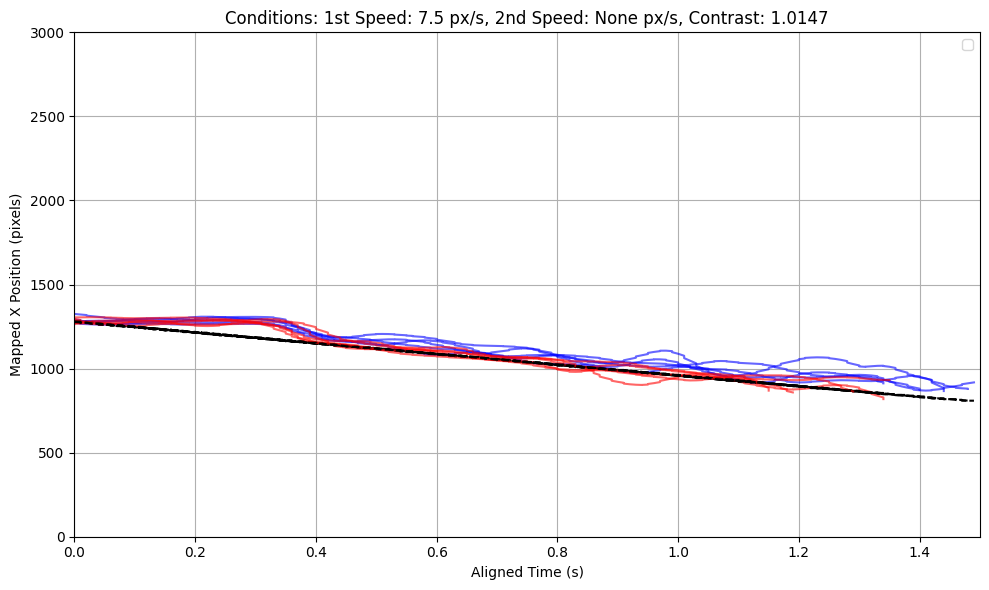

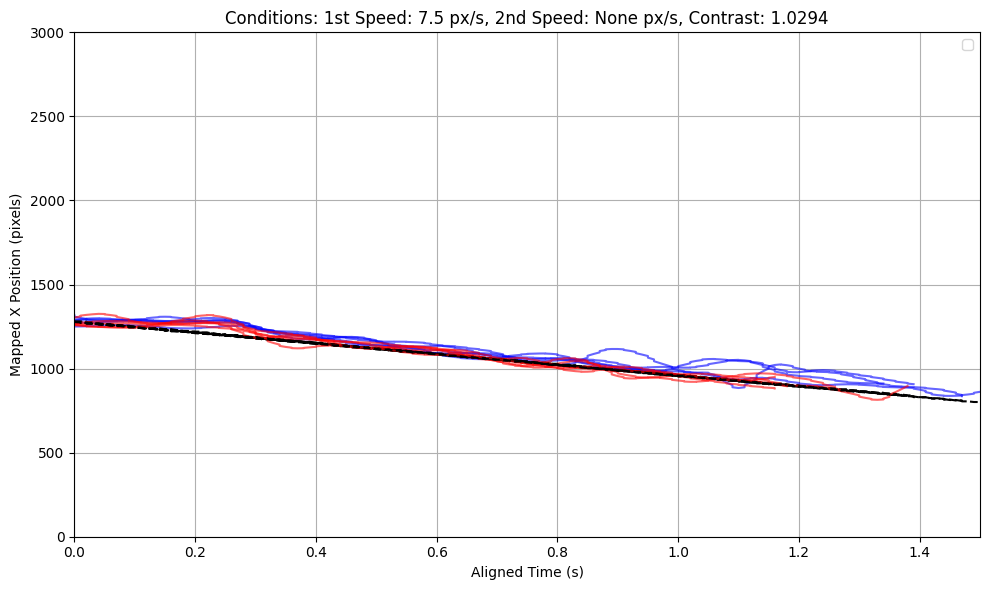

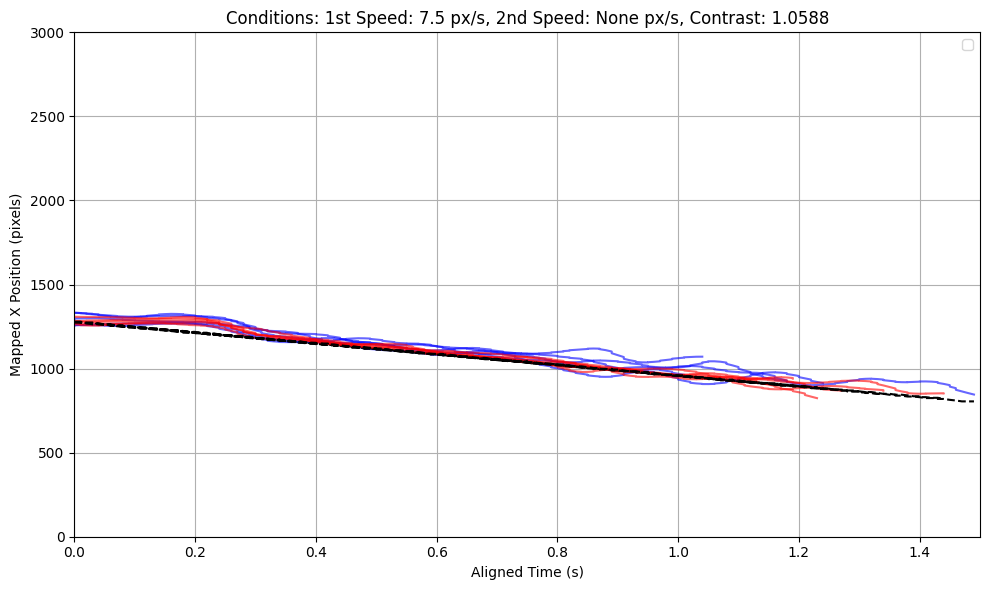

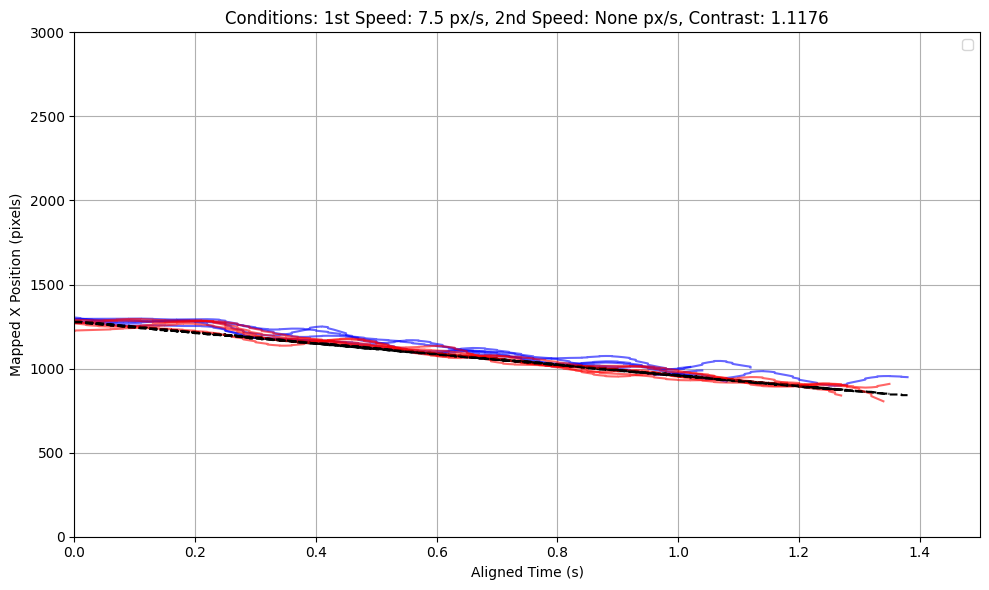

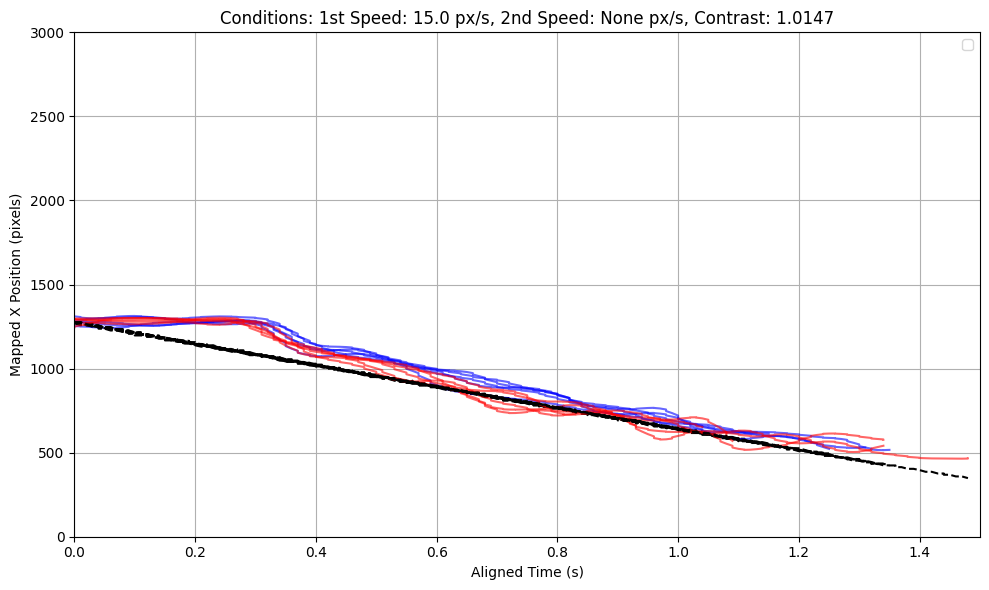

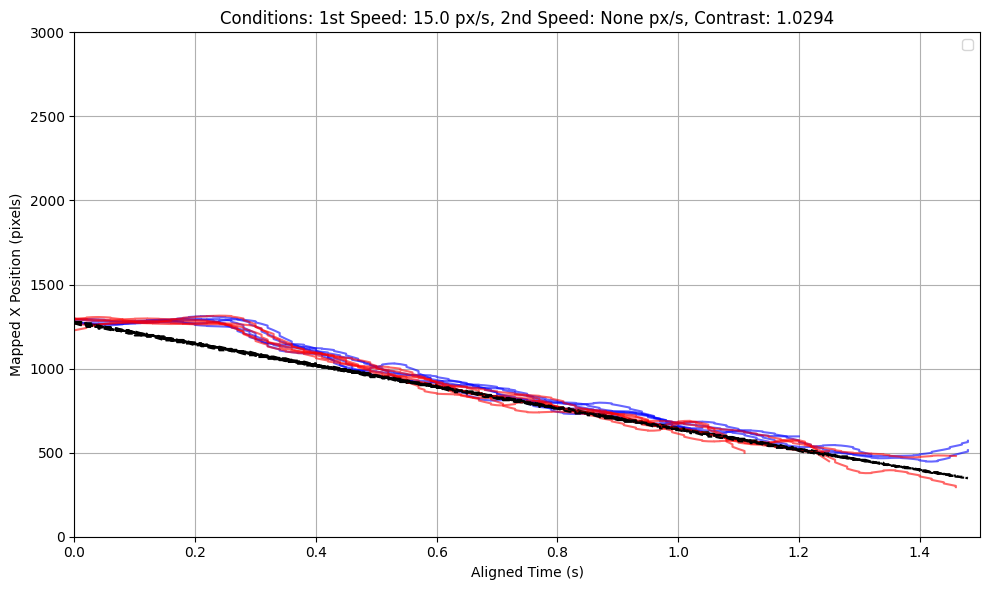

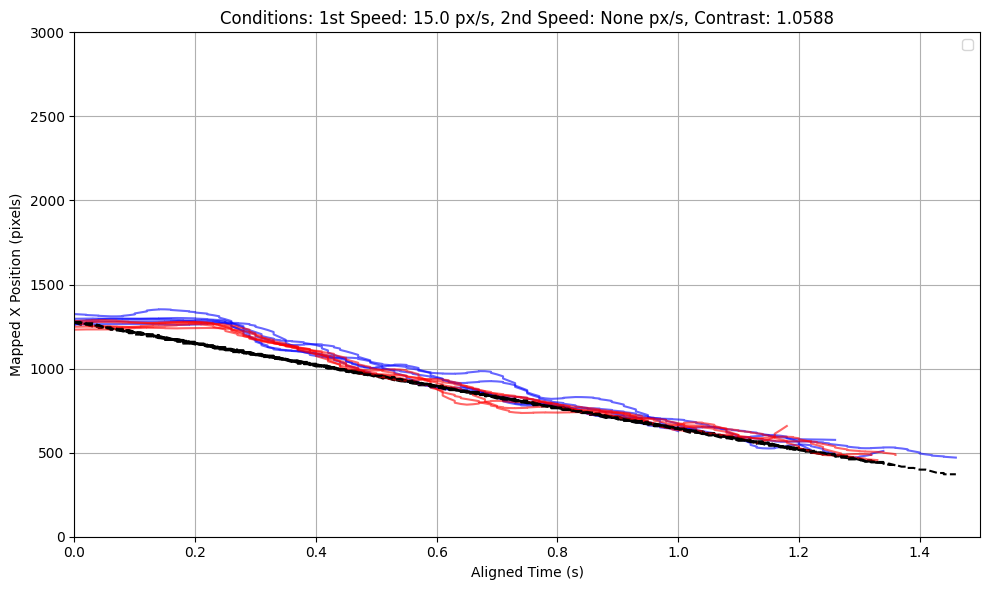

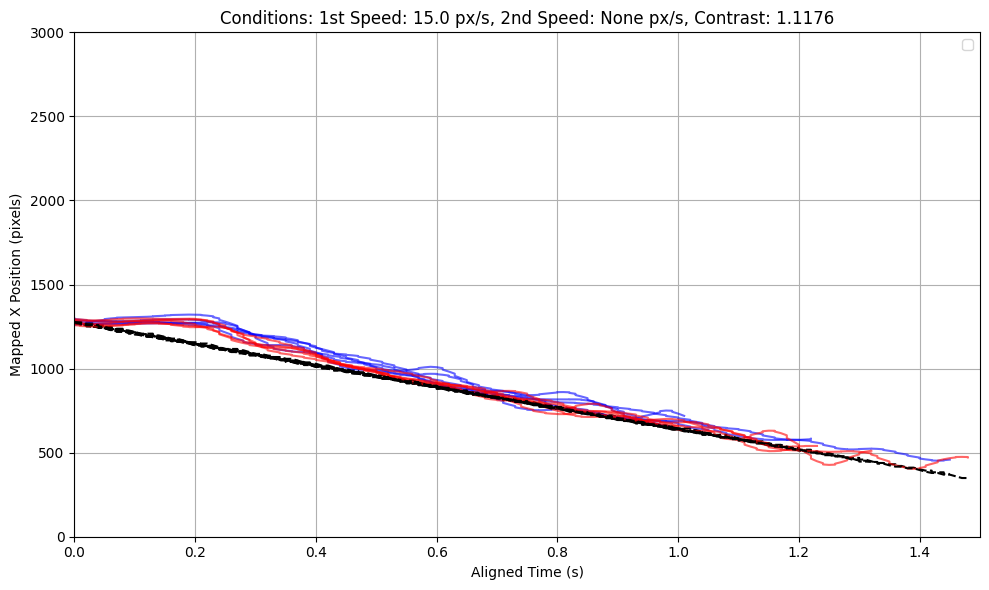

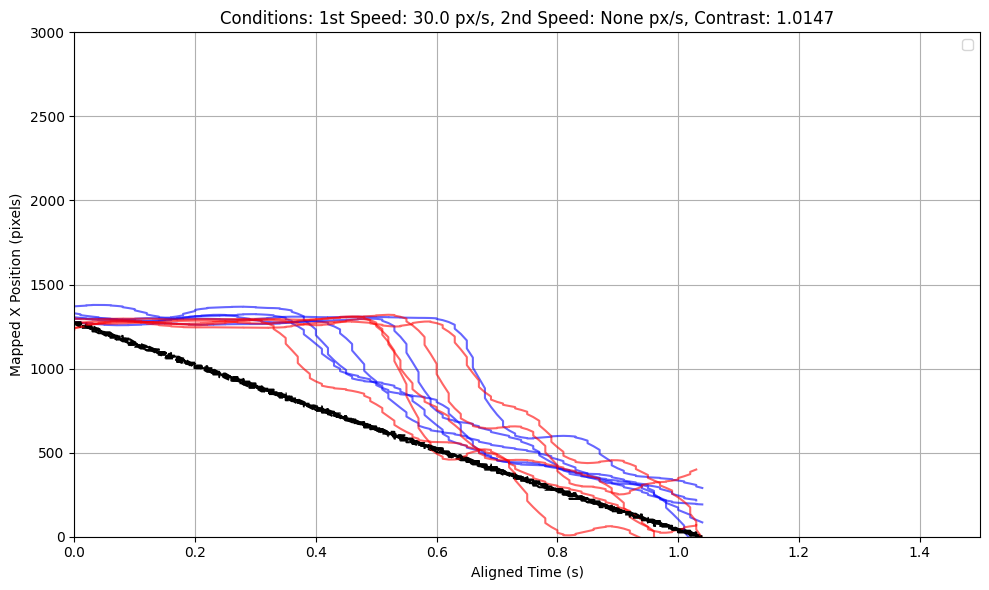

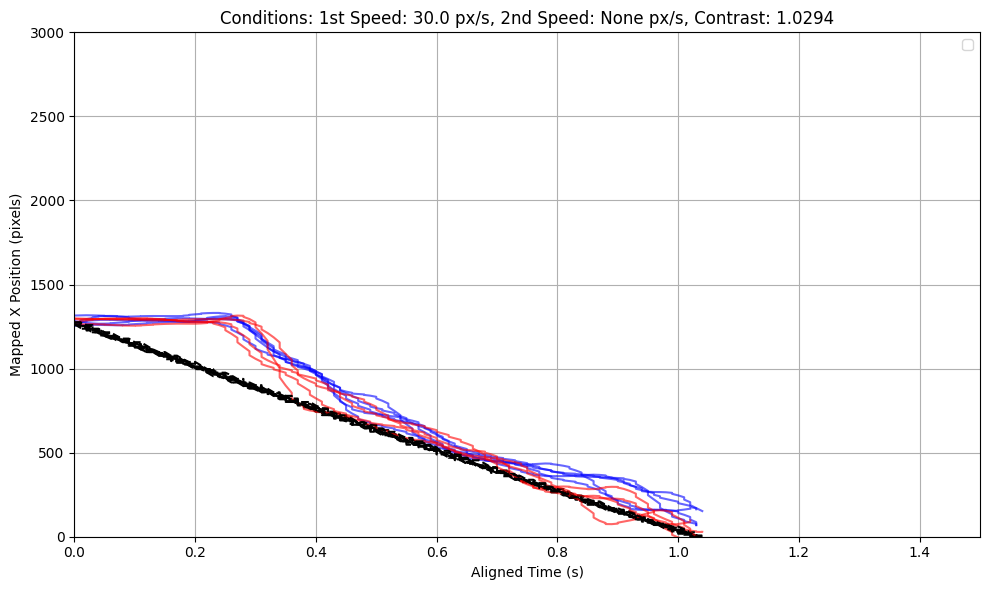

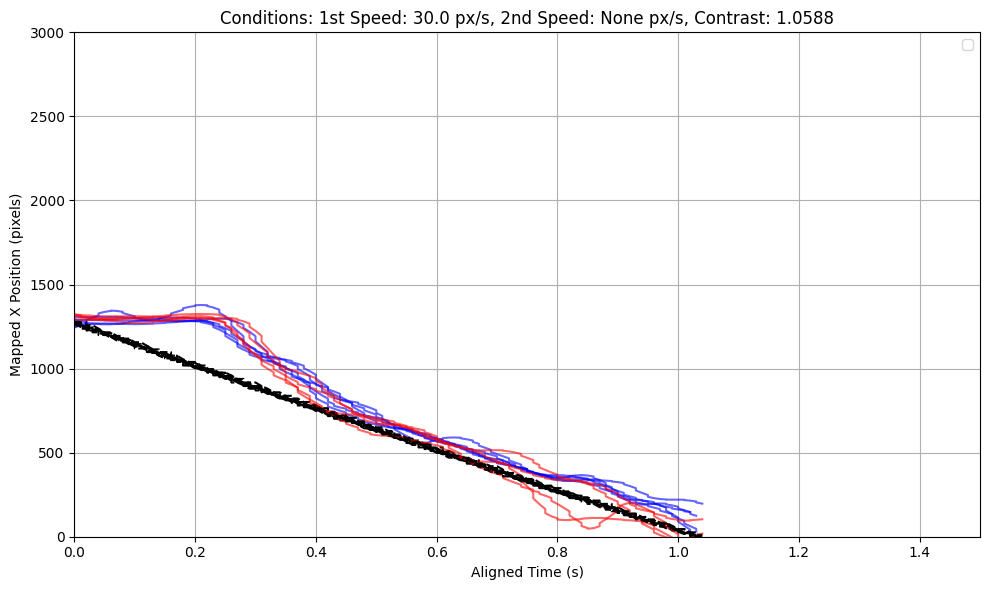

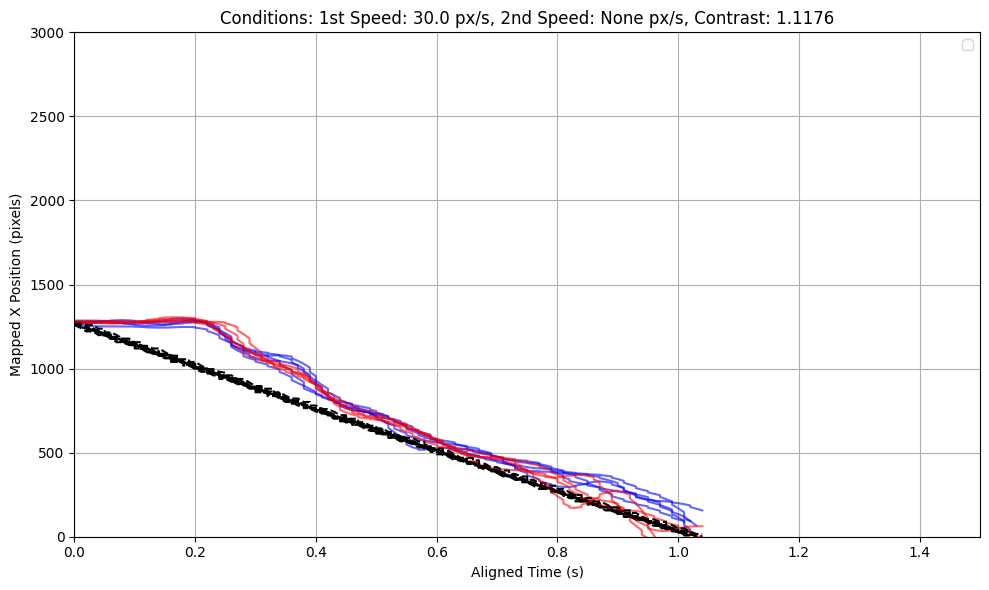

In [133]:
def plot_combined_trials(data, trial_details_df, contrast_threshold_column, time_passed_seconds, angular_threshold, alpha=0.6):
    import matplotlib.pyplot as plt

    # Define colors for directions
    direction_colors = {'horizontal_left': 'blue', 'horizontal_right': 'red'}

    # Group trials by unique conditions including first and second segment speeds and contrast
    grouping_columns = ['first_segment_speed', 'second_segment_speed', 'contrast_threshold_multiplier']
    grouped_trials = trial_details_df.groupby(grouping_columns)

    for group_key, group in grouped_trials:
        # Extract conditions for title
        first_speed, second_speed, contrast_threshold = group_key
        unique_trial_ids = group['trial_id'].unique()

        if len(unique_trial_ids) == 0:
            continue

        # Create a new plot for this group
        plt.figure(figsize=(10, 6))

        for trial_id in unique_trial_ids:
            # Filter data for the current trial ID
            trial_data = data[data['TrialID'] == trial_id]

            if trial_data.empty:
                continue

            # Plot data for each direction
            for direction, motion_x in [('horizontal_left', -1), ('horizontal_right', 1)]:
                # Filter data for the current direction
                direction_data = trial_data[trial_data['object_motion_x'] == motion_x]

                if direction_data.empty:
                    continue

                # Flip the rightward data for overlap
                if direction == 'horizontal_right':
                    direction_data = direction_data.copy()
                    direction_data['FilteredPogX'] = -direction_data['FilteredPogX'] + screen_width
                    direction_data['BallX'] = -direction_data['BallX'] + screen_width

                # Plot data for each trial number within this direction
                for trial_num in direction_data['TrialNumber'].unique():
                    single_trial_data = direction_data[direction_data['TrialNumber'] == trial_num]

                    # Plot filtered gaze X positions
                    plt.plot(
                        single_trial_data['RelativeTime'],
                        single_trial_data['FilteredPogX'],
                        color=direction_colors[direction],
                        alpha=alpha,
                    )

                    # Plot object position as a dashed black line
                    plt.plot(
                        single_trial_data['RelativeTime'],
                        single_trial_data['BallX'],
                        color='black',
                        linestyle='--',
                    )

        # Set plot titles and labels
        title_parts = [
            f"1st Speed: {first_speed} px/s",
            f"2nd Speed: {second_speed} px/s",
            f"Contrast: {contrast_threshold}"
        ]
        plt.title("Conditions: " + ", ".join(title_parts))
        plt.xlabel("Aligned Time (s)")

        if second_speed == None:
            print("lol")
        else:
            plt.xlim(0, 1.5)
            plt.ylim(0, 3000)
        plt.ylabel("Mapped X Position (pixels)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"niall_plots_1/{first_speed}_{second_speed}_contrast_{contrast_threshold}.png")
        # Display the plot
        plt.show()

# Example usage
angular_threshold = 1.2  # Degrees
time_passed_seconds = 0.25
contrast_threshold_column = 'contrast_threshold_multiplier'

plot_combined_trials(data, segment_df, contrast_threshold_column, time_passed_seconds, angular_threshold, alpha=0.6)


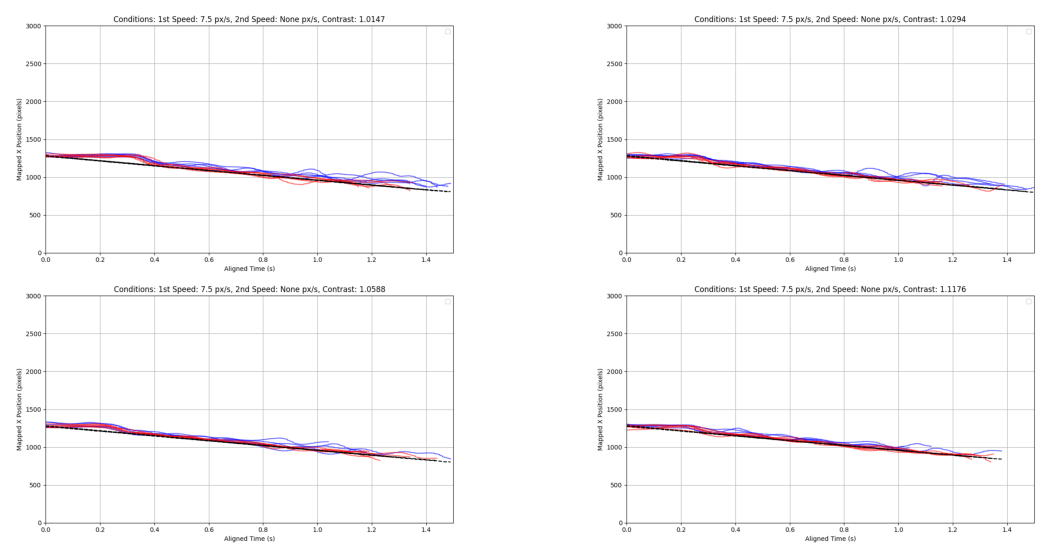

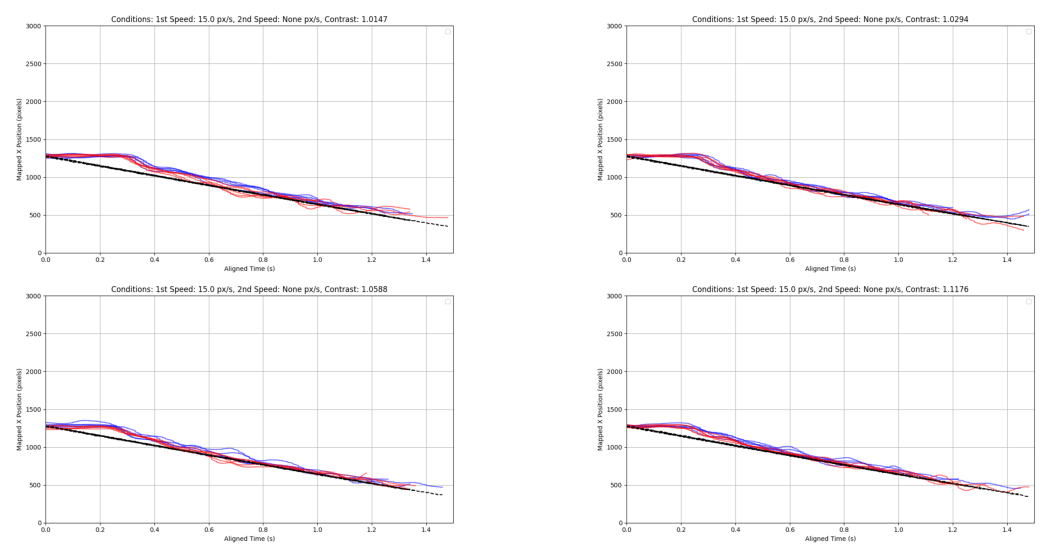

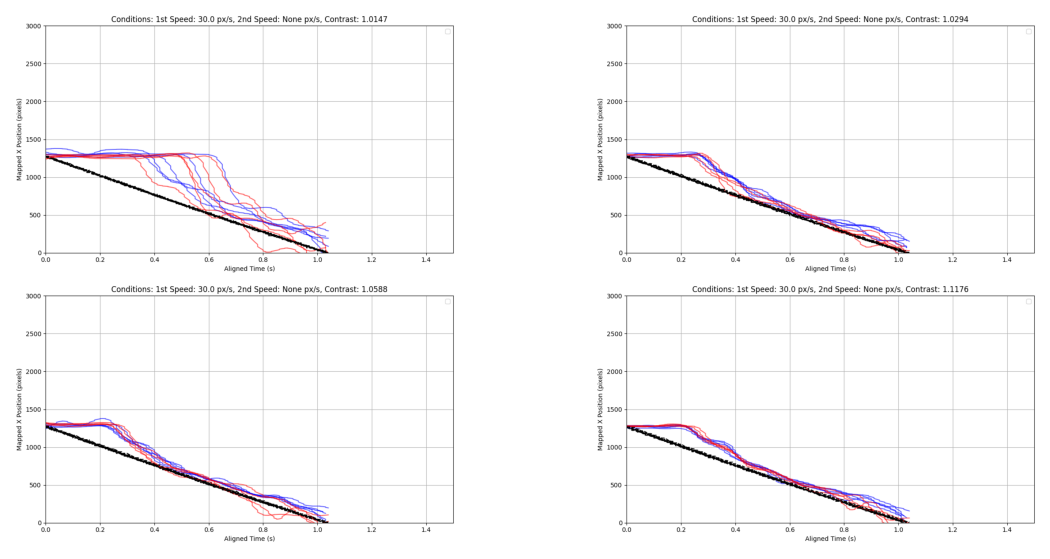

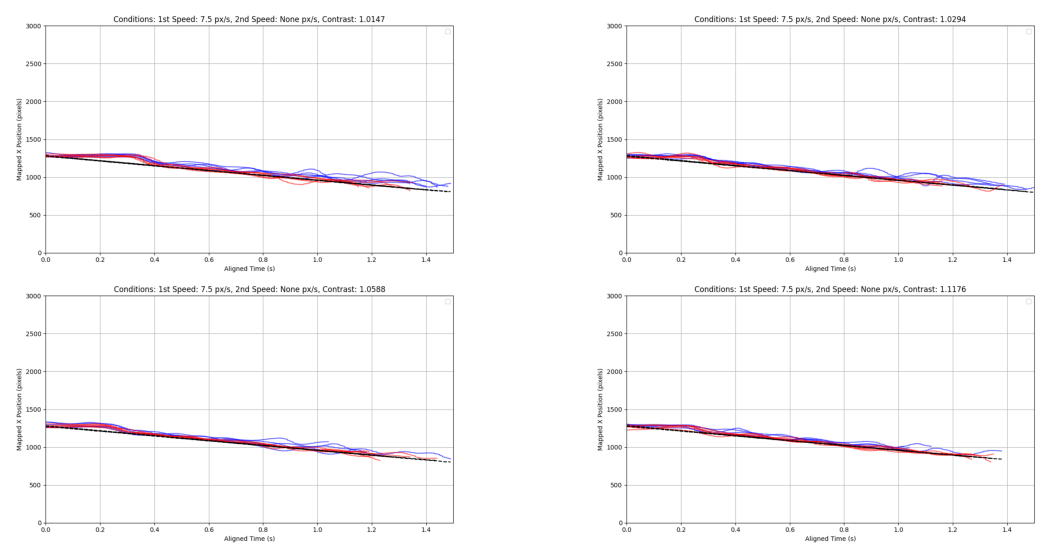

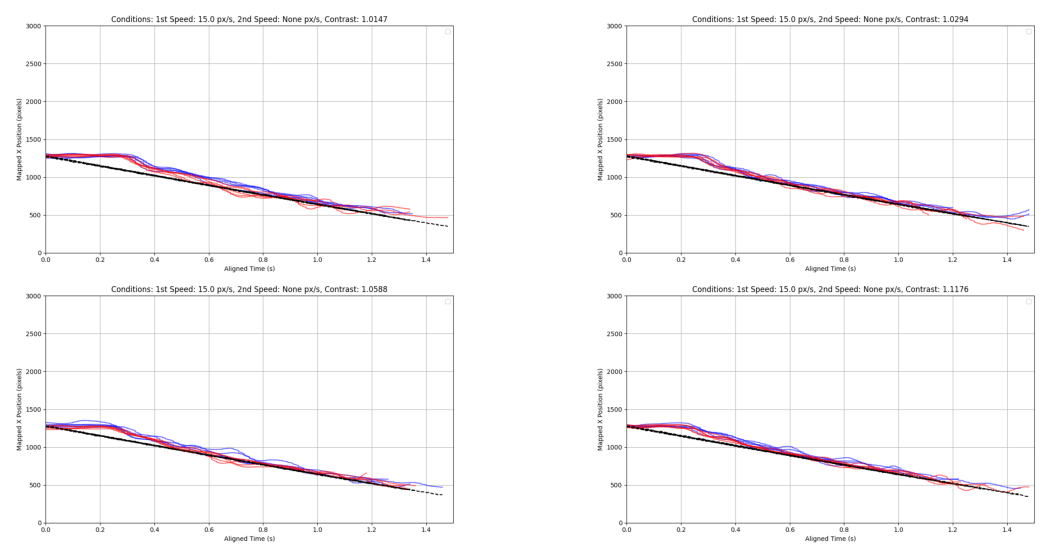

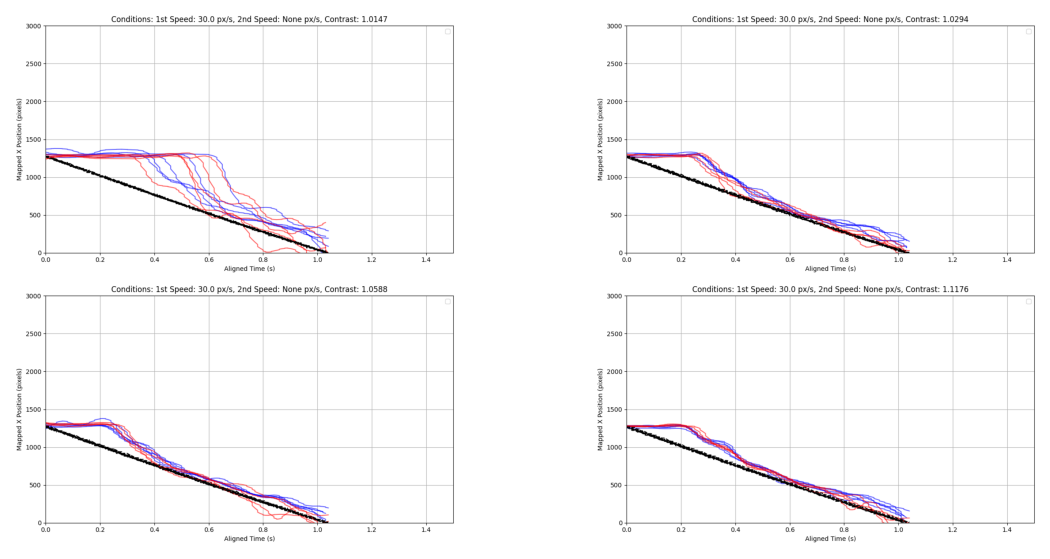

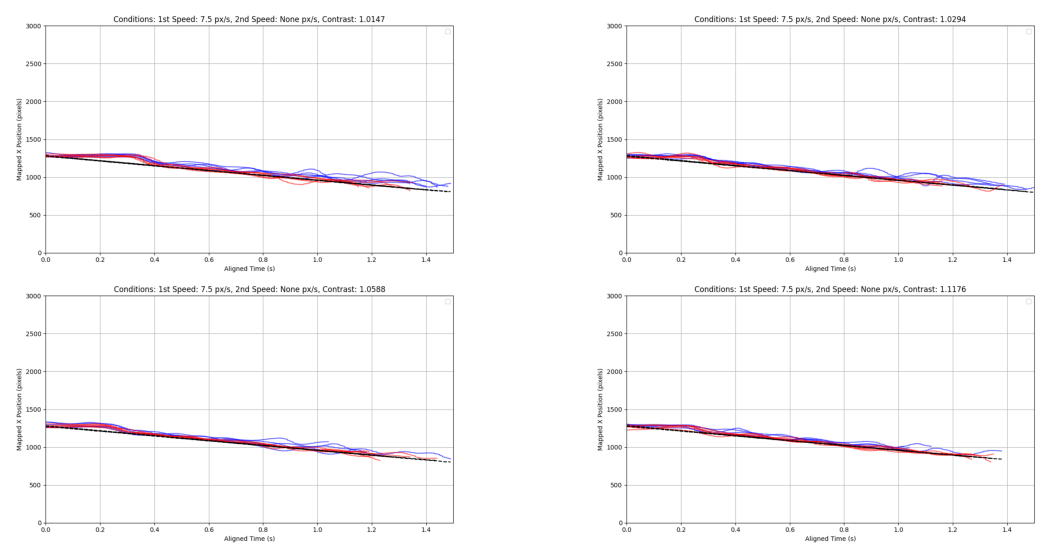

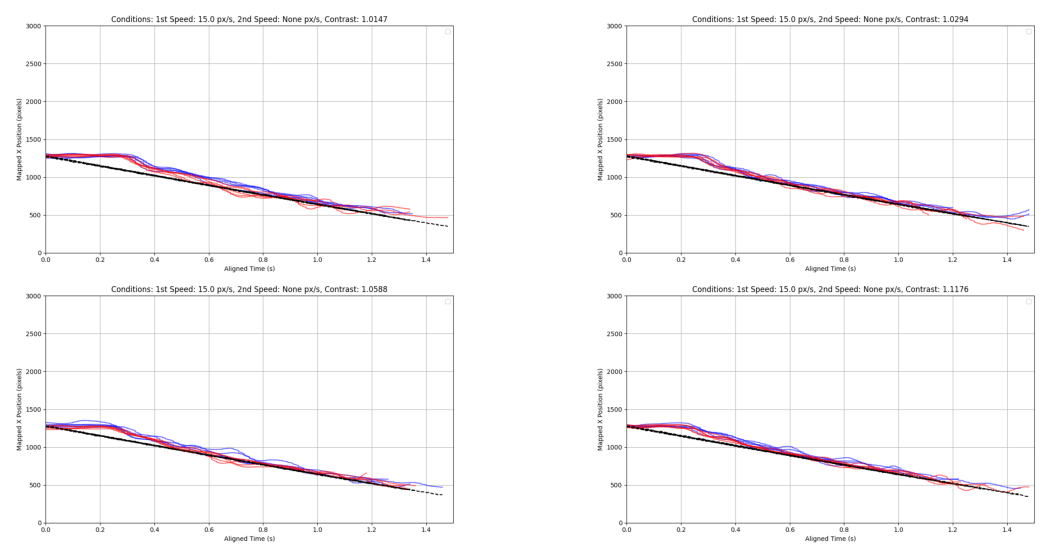

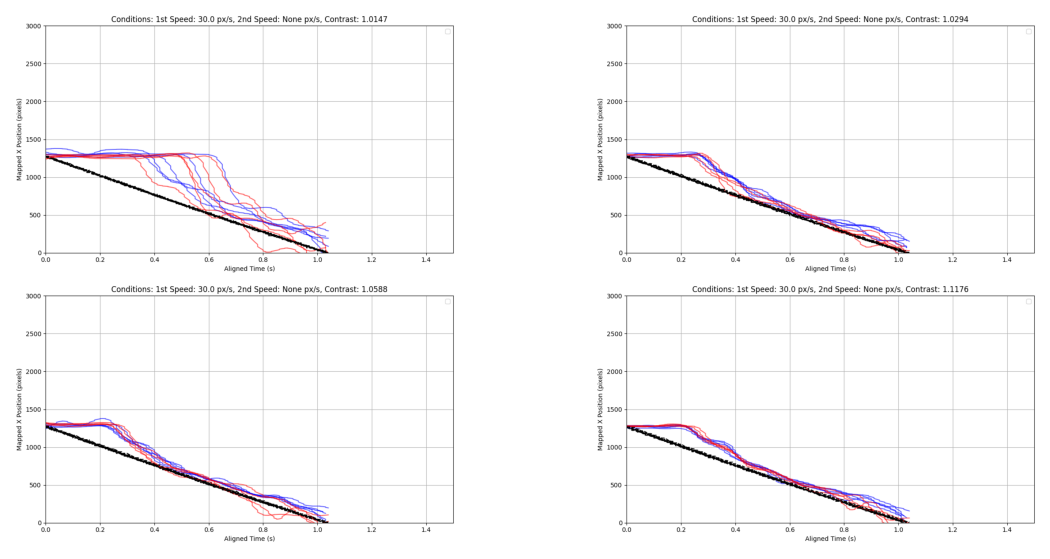

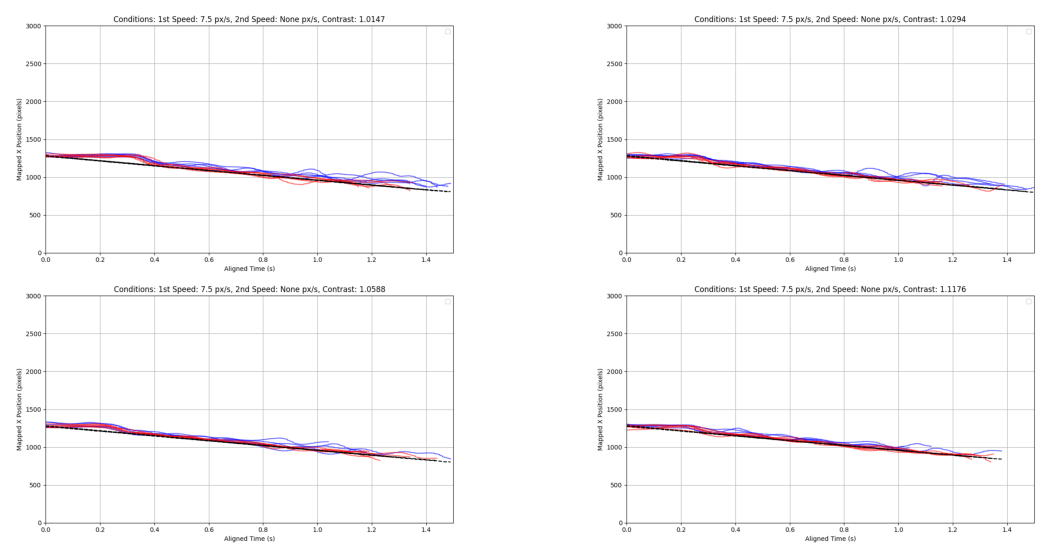

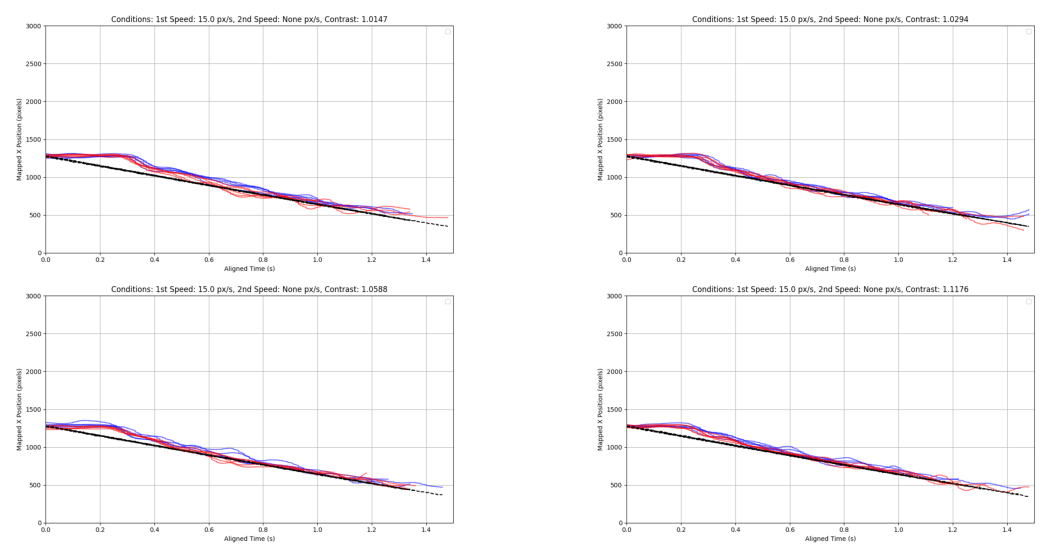

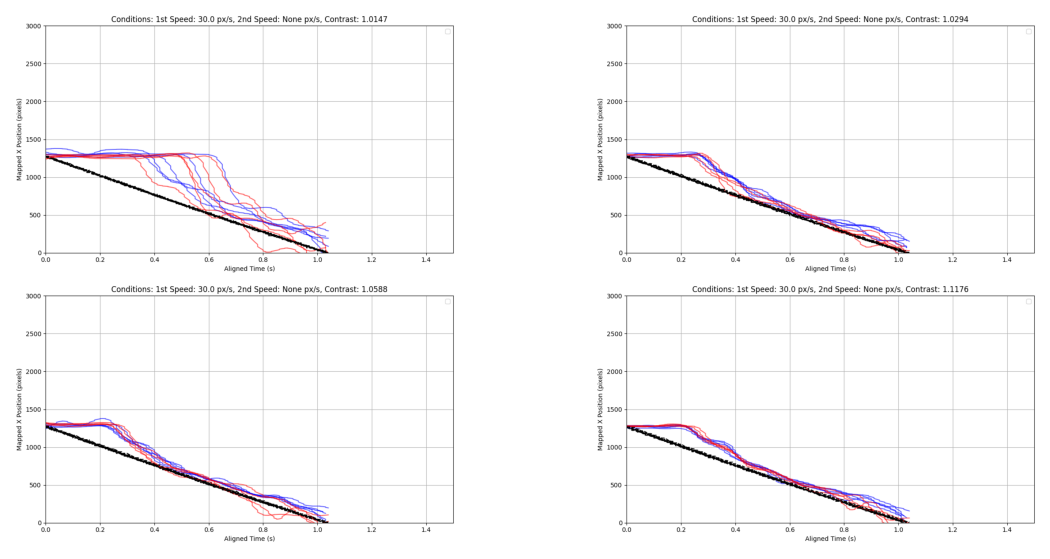

In [134]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import re

# Directory containing the image files
directory = "niall_plots_1"
contrast_JND = 0.0166

contrast_thresholds = [
    1 + contrast_JND, 
    1 + contrast_JND * 2, 
    1 + contrast_JND * 4, 
    1 + contrast_JND * 8,
    # 1.5
    ]

# Supported image file extensions (you can add more if needed)
image_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff"]


def check_image_names(directory, contrast, starting_vel):
    if not os.path.exists(directory):
        print(f"Error: The directory '{directory}' does not exist.")
        return

    matching_files = []

    for filename in os.listdir(directory):
        # Check if the file has an image extension
        if any(filename.lower().endswith(ext) for ext in image_extensions) and filename[0:4] == starting_vel:
            # Check if the target string is in the file name
            match = re.search(r'(\d+\.\d+)_c', filename)
            if match and contrast in filename:
                # Append the matched number and the full file path
                matching_files.append((float(match.group(1)), os.path.join(directory, filename)))
                
def check_image_names_NONE(directory, contrast, starting_vel):
    if not os.path.exists(directory):
        print(f"Error: The directory '{directory}' does not exist.")
        return

    matching_files = []

    for filename in os.listdir(directory):
        # Check if the file has an image extension
        if any(filename.lower().endswith(ext) for ext in image_extensions) and "None" in filename and (filename[0:4] == starting_vel or filename[0:3] == starting_vel):
            matching_files.append(os.path.join(directory, filename))
    matching_files.sort()
    return matching_files

def display_images(image_paths):
    if not image_paths:
        print("No matching images to display.")
        return

    images = [Image.open(path) for path in image_paths]

    # Calculate grid dimensions
    num_images = len(images)
    cols = (num_images + 1) // 2  # 2 rows
    rows = 2

    # Create a figure
    plt.figure(figsize=(15, 7))

    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


# Run the functions
velocities = [
    7.5,
    15.0, 
    30.0
    ]
for thresh in contrast_thresholds:
    for starting_vel in velocities:
        matching_files = check_image_names_NONE(directory, str(thresh), str(starting_vel))
        display_images(matching_files)
